In [31]:
pip install h5py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import astropy.units as u

In [9]:
SGA = Table.read("/global/homes/b/barnerg/DESI_SGA/Morphology/SGA_morph.fits")

In [644]:
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,g_r,r_z,g_z,r90,r50,r20,z50,g50,C_r50_r90,C_r20_r90,m(r50),m(z50),m(g50),Delta(g_r),Delta(g_z),Delta(r_z),HUBBLE_TYPE
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
284583,SGA-2020 284583,PGC1753576,1753576,246.63893700000006,25.882395000000002,E,83.58,0.4168694,0.61659503,0.049369153,23.009481,16.281,False,LEDA-20181114,102768,2MASXJ16263037+2552589_GROUP,3,False,246.63132430980986,25.886678155342814,0.92581606,2465p260,246.63899443421053,25.88239593752038,1.0317777,SB26,89.25743,0.7660097,246.63894134159338,25.882421271706928,21.809486,7.683644,7.267518,6.908575,6.584644,8.19172,10.043491,12.2072115,14.66538,17.695236,21.416355,25.87598,30.953333,16.50979,15.567412,14.869183,16.380758,15.444356,14.747147,16.275633,15.342991,14.648945,16.190153,15.260059,14.5695095,16.121006,15.193452,14.5059595,16.06036,15.134916,14.4499445,16.00693,15.085361,14.402035,15.962352,15.040784,14.35771,15.920147,15.0014,14.320146,0.030591438,0.04308892,0.045999907,0.04829483,0.06055945,0.080751404,0.0973,0.124484144,0.20583051,0.01532438,0.015401917,0.015267819,0.013852132,0.013975341,0.01385223,0.012736728,0.012889164,0.012807729,0.0118285,0.011991284,0.011952993,0.011088653,0.011258294,0.011255878,0.01050395,0.010681791,0.010707616,0.010012423,0.010216223,0.010258886,0.009653168,0.009853663,0.009897824,0.0092963725,0.009511294,0.009575142,15.662999,7318.958,8.404456e-05,0.7656309,0.11777708,14.75623

In [3]:
path = '/pscratch/sd/b/barnerg/Figures/'

In [4]:
fits_file = fits.open(path +'Gal100001.fits')
fits_file[0].header
image_data = fits_file[0].data
fits_file.close()

In [5]:
pixel_values = image_data

In [6]:
pixel_values.shape
#pixel_values

(3, 152, 152)

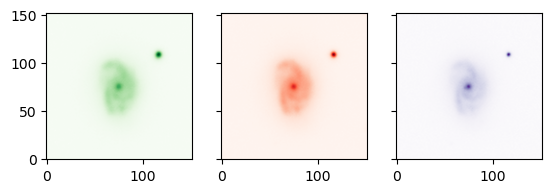

In [7]:
# Reshape the data if needed
# if image_data.shape[0] == 3:
#     image_data = np.transpose(image_data, (1, 2, 0))

plt.figure()
ax1=plt.subplot(131)
plt.imshow(pixel_values[0], origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(pixel_values[1], origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(pixel_values[2], origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [650]:
pixel_values.shape

(3, 152, 152)

In [651]:
image_data.shape

(3, 152, 152)

In [10]:
i=0
while i < len(SGA):
    if SGA['SGA_ID'][i] == 100001:
        print(i)
    i+=1

129248


In [11]:
SGA[:][129248]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,g_r,r_z,g_z,r90,r50,r20,z50,g50,C_r50_r90,C_r20_r90,m(r50),m(z50),m(g50),Delta(g_r),Delta(g_z),Delta(r_z),HUBBLE_TYPE
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
100001,SGA-2020 100001,PGC053818,53818,226.17847799999998,19.0409586,Sc,0.09,0.6067363,0.7979947,0.021173649,23.19848,15.655,False,LEDA-20181114,35811,PGC053818,1,True,226.17847799999998,19.0409586,0.6067363,2260p190,226.17849926458857,19.04083287421329,0.6653861,SB26,1.8628982,0.7361703,226.17842603325033,19.040914899150412,16.814312,5.4667296,5.5622334,5.5493765,9.31231,10.515121,11.788206,13.105426,14.478839,15.835832,17.19523,18.57495,19.961582,15.69349,15.076874,14.609058,15.618643,14.998825,14.52972,15.565383,14.943075,14.473009,15.5276785,14.90346,14.433001,15.500756,14.875368,14.404902,15.482796,14.857162,14.386319,15.470563,14.84409,14.373772,15.462161,14.835689,14.3658905,15.4564,14.8298645,14.360102,0.016252378,0.017275082,0.018330598,0.017856682,0.025278598,0.026416767,0.035207033,0.04450533,0.041077666,0.0050125257,0.0050472682,0.005487466,0.0047369245,0.0047634384,0.005177156,0.004539043,0.0045567052,0.004948065,0.004396116,0.0044056885,0.0047837547,0.004293211,0.0042994265,0.0046597067,0.0042274864,0.0042306096,0.004592975,0.00418092,0.0041824235,0.00453492,0.004151064,0.0041509615,0.0045120167,0.0041298824,0.0041294764,0.004489379,15.436052,0.31233573,0.96949434,3.8852677,0.049322102,14.809952,0.29897,1.

In [12]:
id = 100001
i=0
while i < len(SGA):
    if SGA['SGA_ID'][i] == id:
        RA = SGA['RA'][i]
        DEC = SGA['DEC'][i]
        D26 = SGA['D26'][i]
        print('RA = ',RA)
        print('DEC = ',DEC)
        print('D26 = ' ,D26,'arcmins')
        
    i+=1



RA =  226.17849926458857
DEC =  19.04083287421329
D26 =  0.6653861 arcmins


In [13]:
hdulist = fits.open('/pscratch/sd/b/barnerg/Figures/Gal100001.fits')
wcs = WCS(hdulist[0].header)

# Define a sky coordinate
c = SkyCoord(ra=RA, dec=DEC, unit='deg')

# Convert the sky coordinate to pixel coordinates
x, y = skycoord_to_pixel(c, wcs)

print('Pixel coordinate: ({}, {})'.format(x, y))

Pixel coordinate: (75.22380134242968, 73.77247012278471)


In [14]:
# Define the radius in arcminutes
r = D26/2
radius_arcsec = r*60

# pixel scale of 0.25 arcsec/pixel 
# Define the pixel scale of the image
pixel_scale = 0.25 

# Convert the radius to pixels
radius_pixels = (radius_arcsec / pixel_scale)
print(radius_pixels)

79.84632968902588


In [15]:
# Define the properties of the circle
radius = radius_pixels
center_x, center_y = x, y

# Create a grid of pixel coordinates
a, b = np.meshgrid(np.arange(0, 152), np.arange(0, 152))

# Calculate the distance between each pixel and the center of the circle
dist = np.sqrt((a - center_x)**2 + (b - center_y)**2)

# Create a binary mask based on the circle radius
mask = np.where(dist <= 40, 1, 0)
print(mask.shape)
# Apply the mask to your original numpy array
green = pixel_values[0] * mask
red = pixel_values[1] * mask
purple = pixel_values[2] * mask

(152, 152)


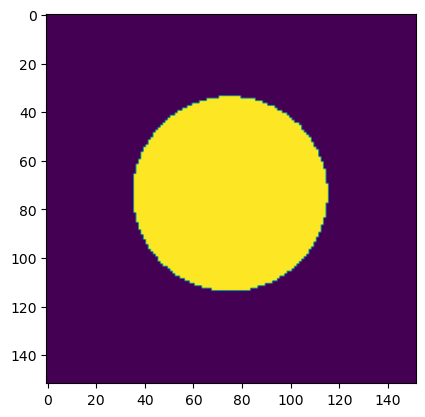

In [16]:
plt.imshow(mask)

In [17]:
np.shape(my_array_masked)

NameError: name 'my_array_masked' is not defined

In [18]:
#np.sort(my_array_masked)

In [19]:
np.unique(my_array_masked)

NameError: name 'my_array_masked' is not defined

NameError: name 'my_array_masked' is not defined

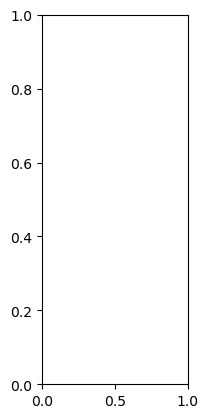

In [20]:

# Display the image
# plt.imshow(my_array_masked)
# plt.show()

plt.figure()
ax1=plt.subplot(131)
plt.imshow(my_array_masked[:,:,0], origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(my_array_masked[:,:,1], origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(my_array_masked[:,:,2], origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [21]:
g = np.ravel(np.array(green))
r = np.ravel(np.array(red))
p = np.ravel(np.array(purple))

In [22]:
gp = g[g > 0]
rp = r[r > 0]
pp = p[p > 0]

In [23]:
# plt.hist(gp, bins =70)
# plt.hist(rp, bins = 70)
# plt.hist(pp, bins = 70)

In [24]:
n = len(gp)
    
sorted_arr = np.sort(gp)
    
numerator = np.sum([((2*i - n - 1) * sorted_arr[i-1]) for i in range(1, n+1)])

denominator =  np.mean(sorted_arr)*n*(n-1)

gini_g = (numerator) / (denominator)
                      
print('gini_green =',gini_g)

gini_green = 0.4567678426798266


In [25]:
n = len(rp)
    
sorted_arr = np.sort(rp)
    
numerator = np.sum([((2*i - n - 1) * sorted_arr[i-1]) for i in range(1, n+1)])

denominator =  np.mean(sorted_arr)*n*(n-1)

gini_r = (numerator) / (denominator)
                      
print('gini_red =',gini_r)

gini_red = 0.45362307084198644


In [26]:
n = len(pp)
    
sorted_arr = np.sort(pp)
    
numerator = np.sum([((2*i - n - 1) * sorted_arr[i-1]) for i in range(1, n+1)])

denominator =  np.mean(sorted_arr)*n*(n-1)

gini_p = (numerator) / (denominator)
                      
print('gini_purple =',gini_p)

gini_purple = 0.46051977117667736


In [27]:
all = np.add(gp, rp, pp)

In [31]:
n = len(all)
    
sorted_arr = np.sort(all)
    
numerator = np.sum([((2*i - n - 1) * sorted_arr[i-1]) for i in range(1, n+1)])

denominator =  np.mean(sorted_arr)*n*(n-1)

gini_all = (numerator) / (denominator)
                      
print('gini_all =',gini_all)

gini_all = 0.4545861713307323


In [32]:
#TEST
arr = np.array([1, 4, 2, 6, 3, 5])

n = len(arr)
    
sorted_arr = np.sort(arr)
    
numerator = np.sum([((2*i - n - 1) * sorted_arr[i-1]) for i in range(1, n+1)])

denominator =  np.mean(sorted_arr)*n*(n-1)

gini_coeff = (numerator) / (denominator)
                      
print(gini_coeff)

0.3333333333333333


In [33]:
#sorted_arr
print(denominator)

#sorted_arr

105.0
